In [4]:
!unzip data.zip

Archive:  data.zip
  inflating: APPLE_DISEASE_DATASET/APPLE ROT LEAVES/1036.JPG.jpeg  
  inflating: APPLE_DISEASE_DATASET/APPLE ROT LEAVES/1062.jpg.jpeg  
  inflating: APPLE_DISEASE_DATASET/APPLE ROT LEAVES/1070.jpg.jpeg  
  inflating: APPLE_DISEASE_DATASET/APPLE ROT LEAVES/1079.jpg.jpeg  
  inflating: APPLE_DISEASE_DATASET/APPLE ROT LEAVES/1080.jpg.jpeg  
  inflating: APPLE_DISEASE_DATASET/APPLE ROT LEAVES/1082.jpg.jpeg  
  inflating: APPLE_DISEASE_DATASET/APPLE ROT LEAVES/1084.jpg.jpeg  
  inflating: APPLE_DISEASE_DATASET/APPLE ROT LEAVES/1086.jpg.jpeg  
  inflating: APPLE_DISEASE_DATASET/APPLE ROT LEAVES/1092.jpg.jpeg  
  inflating: APPLE_DISEASE_DATASET/APPLE ROT LEAVES/1094.jpg.jpeg  
  inflating: APPLE_DISEASE_DATASET/APPLE ROT LEAVES/1095.jpg.jpeg  
  inflating: APPLE_DISEASE_DATASET/APPLE ROT LEAVES/1096.jpg.jpeg  
  inflating: APPLE_DISEASE_DATASET/APPLE ROT LEAVES/1098.jpg.jpeg  
  inflating: APPLE_DISEASE_DATASET/APPLE ROT LEAVES/2000.jpg.jpeg  
  inflating: APPLE_DISEASE_DA

In [2]:
#@title 2. 필수 라이브러리 임포트
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from glob import glob # (EDA를 위한 파일 개수 카운팅용)

# Scikit-learn (결과 평가용)
from sklearn.metrics import confusion_matrix, classification_report

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [5]:
#@title 3. 데이터 경로 및 하이퍼파라미터 설정

# ----------------------------------------------------------------------
# [중요!] 사용자의 Google Drive에 업로드된 데이터셋의 *기본 경로*를 입력하세요.
# 예: '/content/drive/MyDrive/data/Apple_Disease/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
# (이 경로는 4개의 클래스 폴더(Apple___Apple_scab, ...)가 직접 포함된 경로여야 합니다.)
# ----------------------------------------------------------------------
DATASET_PATH = "/content/data/APPLE_DISEASE_DATASET" # <--- 이 경로를 수정하세요

# 모델 하이퍼파라미터
IMG_SIZE = (224, 224) # MobileNetV2는 (224, 224)를 권장
BATCH_SIZE = 32
BUFFER_SIZE = tf.data.AUTOTUNE
VALIDATION_SPLIT = 0.2 # 훈련 데이터 중 20%를 검증용으로 사용
SEED = 42
EPOCHS = 20 # (전이 학습은 비교적 적은 Epochs로도 수렴 가능)

In [6]:
#@title 4. [EDA 보강] 클래스 분포 확인 (Bar Plot - 영문)
# (데이터를 tf.data로 로드하기 전에, 디렉토리의 실제 파일 수를 먼저 카운트합니다.)

print("Analyzing class distribution in directory...")
class_paths = glob(os.path.join(DATASET_PATH, '*'))
class_names_eng = sorted([os.path.basename(p) for p in class_paths if os.path.isdir(p)])
NUM_CLASSES = len(class_names_eng)

print(f"Found {NUM_CLASSES} classes:")
print(class_names_eng)

Analyzing class distribution in directory...
Found 4 classes:
['APPLE ROT LEAVES', 'HEALTHY LEAVES', 'LEAF BLOTCH', 'SCAB LEAVES']


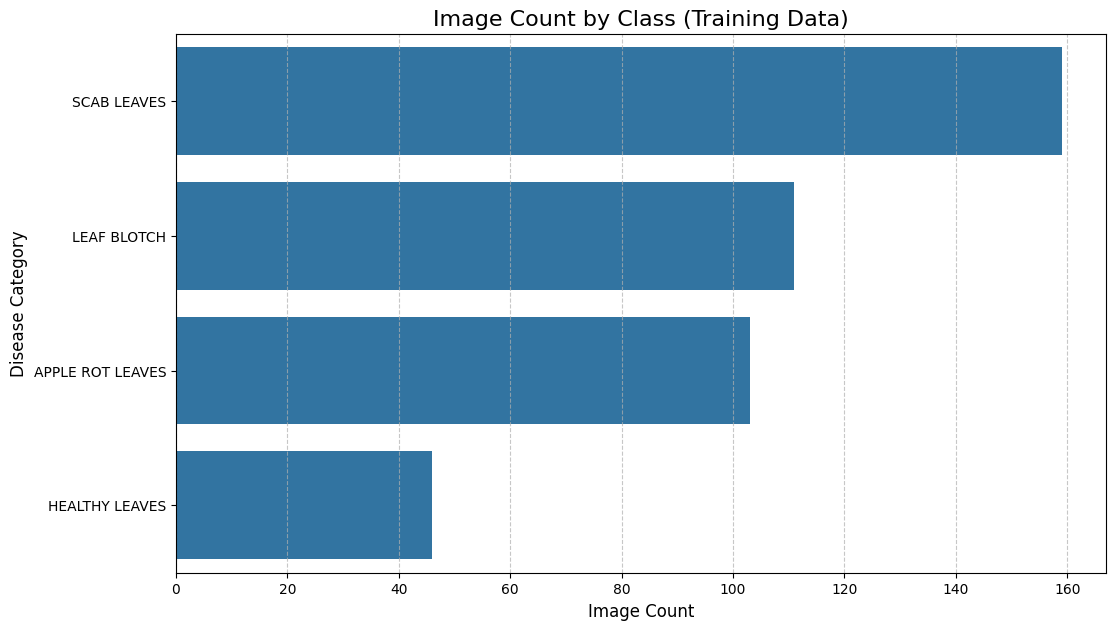


Analysis: The dataset appears to be well-balanced.


In [8]:
# 각 클래스별 이미지 개수 카운트
class_counts = []
for class_name in class_names_eng:
    count = len(os.listdir(os.path.join(DATASET_PATH, class_name)))
    class_counts.append(count)

# 시각화를 위한 DataFrame 생성
df_counts = pd.DataFrame({
    'ClassName': class_names_eng,
    'Count': class_counts
}).sort_values(by='Count', ascending=False)

# 클래스 분포 시각화
plt.figure(figsize=(12, 7))
sns.barplot(data=df_counts, y='ClassName', x='Count', orient='h')
plt.title('Image Count by Class (Training Data)', fontsize=16)
plt.xlabel('Image Count', fontsize=12)
plt.ylabel('Disease Category', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("\nAnalysis: The dataset appears to be well-balanced.")

In [9]:
#@title 5. 데이터 로드 및 분리 (tf.data Pipeline)

# 1. 훈련 데이터셋 (Training Dataset) 로드
# image_dataset_from_directory를 사용하여 훈련 데이터의 80%를 로드합니다.
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 419 files belonging to 4 classes.
Using 336 files for training.


In [10]:
# 2. 검증 데이터셋 (Validation Dataset) 로드
# image_dataset_from_directory를 사용하여 훈련 데이터의 20%를 로드합니다.
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# (참고: 원본 코드의 'test_ds'는 이 데이터셋의 'valid' 폴더를 사용했을 수 있습니다.
# 여기서는 훈련셋에서 분리한 val_ds를 최종 테스트(평가) 용도로도 사용합니다.)

# 클래스 이름 확인 (영문)
class_names = train_ds.class_names
print("\nClass names loaded by TensorFlow:")
print(class_names)


Found 419 files belonging to 4 classes.
Using 83 files for validation.

Class names loaded by TensorFlow:
['APPLE ROT LEAVES', 'HEALTHY LEAVES', 'LEAF BLOTCH', 'SCAB LEAVES']


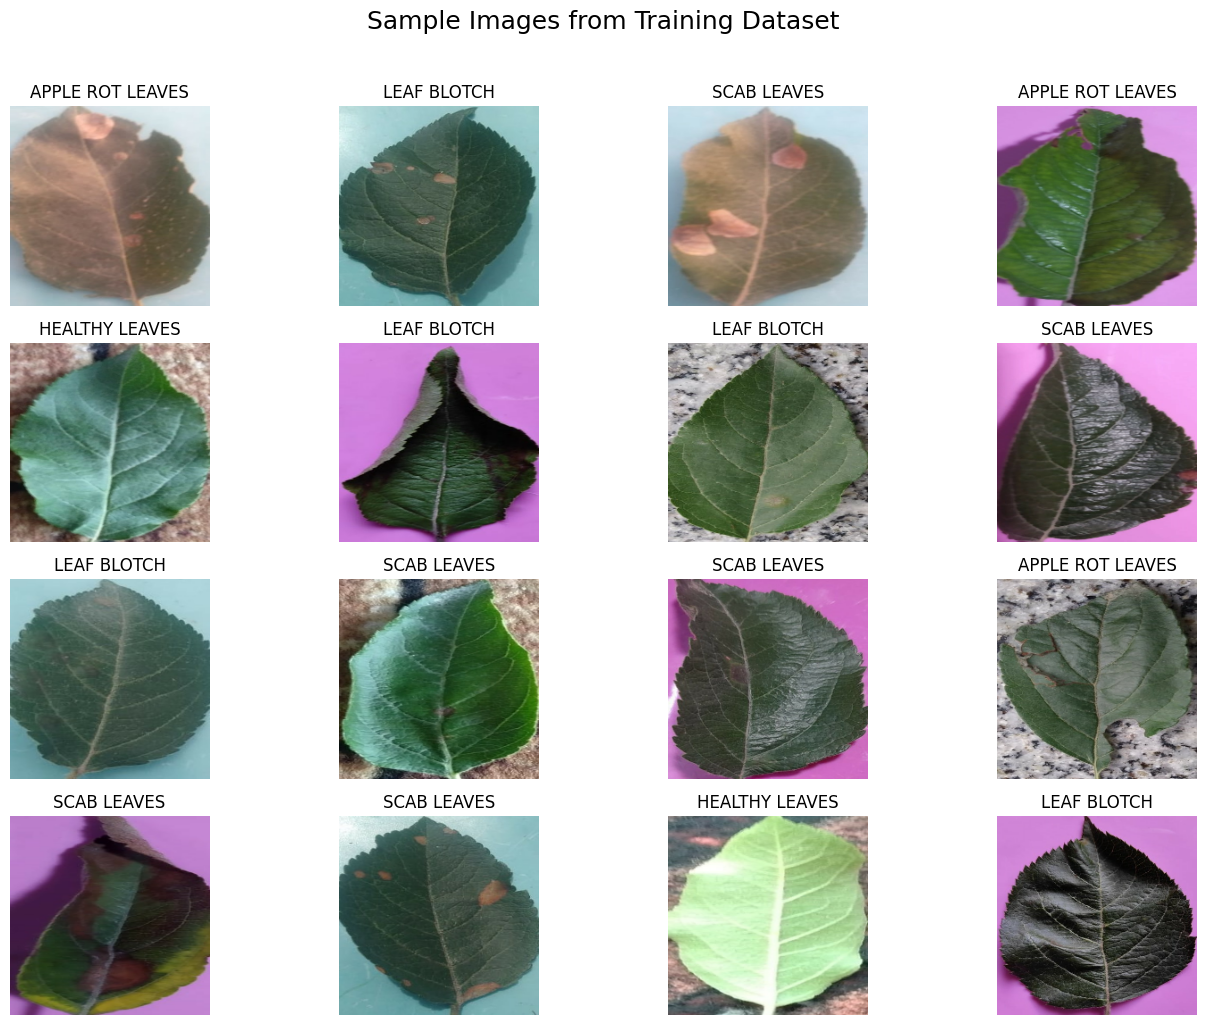

In [11]:
#@title 6. [EDA 보강] 샘플 이미지 시각화 (Image Grid - 영문)

plt.figure(figsize=(14, 10))
plt.suptitle('Sample Images from Training Dataset', fontsize=18, y=1.02)

# 훈련 데이터셋에서 1개의 배치(32개 이미지)를 가져옵니다.
for images, labels in train_ds.take(1):
    for i in range(16): # 16개(4x4)만 표시
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]]) # 영문 클래스 이름
        plt.axis("off")

plt.tight_layout()
plt.show()



Visualizing Data Augmentation Effect...


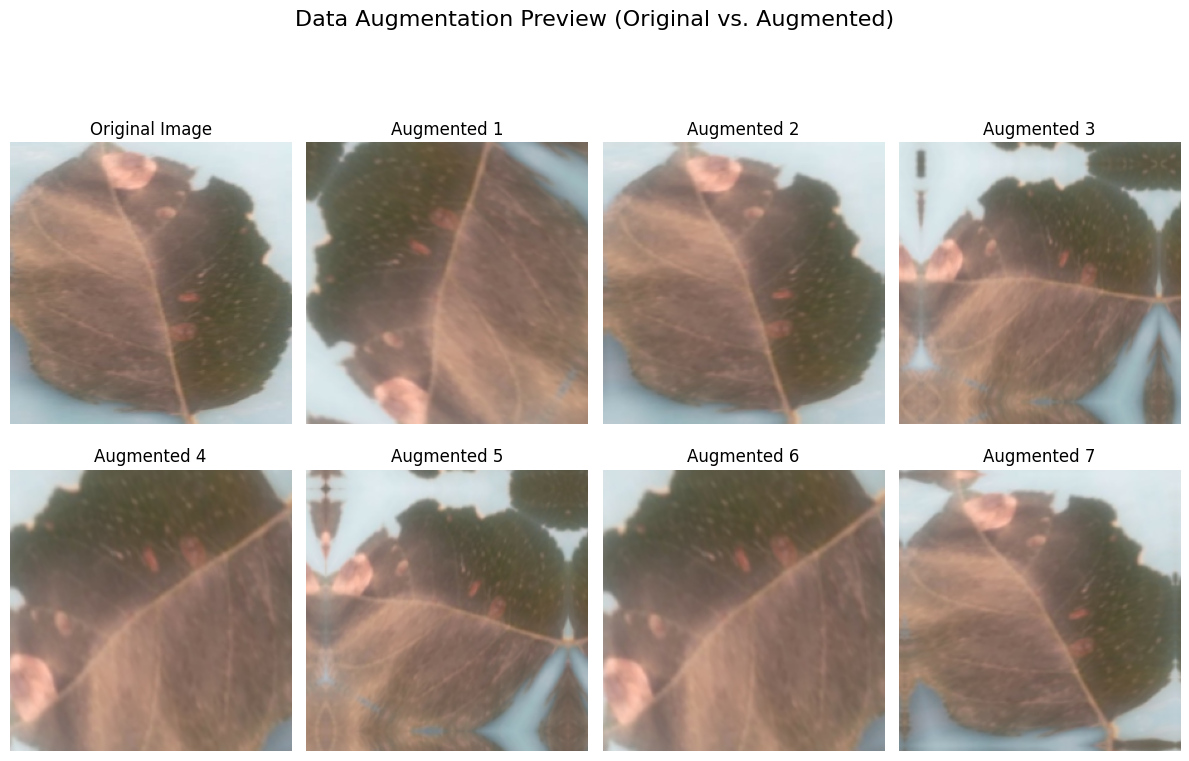

In [12]:
#@title 7. [EDA 보강] 데이터 증강(Augmentation) 정의 및 시각화

# Keras 전처리 레이어를 사용한 데이터 증강 파이프라인 정의
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical", seed=SEED),
    RandomRotation(0.2, seed=SEED),
    RandomZoom(0.2, seed=SEED)
], name="data_augmentation")

# [시각화 보강] 증강 효과 미리보기
print("\nVisualizing Data Augmentation Effect...")
plt.figure(figsize=(12, 8))
plt.suptitle('Data Augmentation Preview (Original vs. Augmented)', fontsize=16, y=1.03)

# 위에서 가져온 샘플 이미지 배치(images) 중 첫 번째 이미지를 사용
sample_image = images[0]

for i in range(8): # 원본 1장 + 증강 7장
    ax = plt.subplot(2, 4, i + 1)
    if i == 0:
        # 원본 이미지
        plt.imshow(sample_image.numpy().astype("uint8"))
        plt.title("Original Image")
    else:
        # 증강된 이미지
        augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(f"Augmented {i}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

In [13]:
#@title 8. 데이터셋 파이프라인 최적화 (Augmentation 적용)

# 1. 입력 픽셀 값 정규화 (MobileNetV2용 전처리)
# MobileNetV2는 픽셀 값을 [-1, 1] 범위로 스케일링하는 것을 권장합니다.
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# 2. 파이프라인 구성 (성능 최적화: prefetch, cache)
# 훈련 데이터셋 (Augmentation 적용)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=BUFFER_SIZE)
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=BUFFER_SIZE)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=BUFFER_SIZE)

# 검증 데이터셋 (Augmentation 미적용, 정규화만 적용)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=BUFFER_SIZE)
val_ds = val_ds.cache().prefetch(buffer_size=BUFFER_SIZE)

print("\nData pipelines configured with augmentation (train only) and normalization.")



Data pipelines configured with augmentation (train only) and normalization.


In [14]:
#@title 9. MobileNetV2 전이 학습(Transfer Learning) 모델 구축

# 1. 사전 학습된 기본 모델(Base Model) 로드 (MobileNetV2)
# include_top=False: 분류기 레이어(최상층)는 제외하고 특징 추출기만 가져옵니다.
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,), # (224, 224, 3)
    include_top=False,
    weights='imagenet'
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# 2. 기본 모델의 가중치 동결 (Freeze)
# (사전 학습된 가중치가 훈련 중에 업데이트되지 않도록 설정)
base_model.trainable = False

# 3. 새로운 분류기(Classifier) 정의 (전이 학습)
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False) # (training=False: BN 레이어가 추론 모드로 동작)
x = GlobalAveragePooling2D()(x) # 특징 맵을 벡터로 변환
x = Dropout(0.3)(x) # 과적합 방지
outputs = Dense(NUM_CLASSES, activation='softmax')(x) # 4개 클래스 출력

In [16]:
# 4. 최종 모델 결합
model = Model(inputs, outputs)

In [17]:
# 5. 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', # (라벨이 정수형이므로 'sparse_' 사용)
    metrics=['accuracy']
)

# 모델 요약
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
#@title 10. 모델 학습 (Early Stopping 적용)

# 과적합 방지 및 최적 모델 저장을 위한 EarlyStopping 콜백
early_stopper = EarlyStopping(
    monitor='val_loss', # 검증 손실(val_loss)을 모니터링
    patience=5,         # 5 에포크 동안 개선되지 않으면 중지
    verbose=1,
    restore_best_weights=True # 가장 성능이 좋았던 시점의 가중치로 복원
)

print("\nStarting model training...")

# 모델 학습
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopper]
)

print("\nModel training finished.")


Starting model training...
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.2504 - loss: 1.9682 - val_accuracy: 0.3976 - val_loss: 1.2701
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3727 - loss: 1.5812 - val_accuracy: 0.4458 - val_loss: 1.1600
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.4100 - loss: 1.3185 - val_accuracy: 0.5181 - val_loss: 1.1142
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5549 - loss: 1.1348 - val_accuracy: 0.5663 - val_loss: 1.0906
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5285 - loss: 1.1047 - val_accuracy: 0.5422 - val_loss: 1.0665
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6230 - loss: 0.9396 - val_accuracy: 0.5060 - val_loss: 1.0526
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6005 - loss: 0.9132 - val_accuracy: 0.5663 - val_loss: 1.0192
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5972 - loss: 0.9489 - val_


Plotting training history...


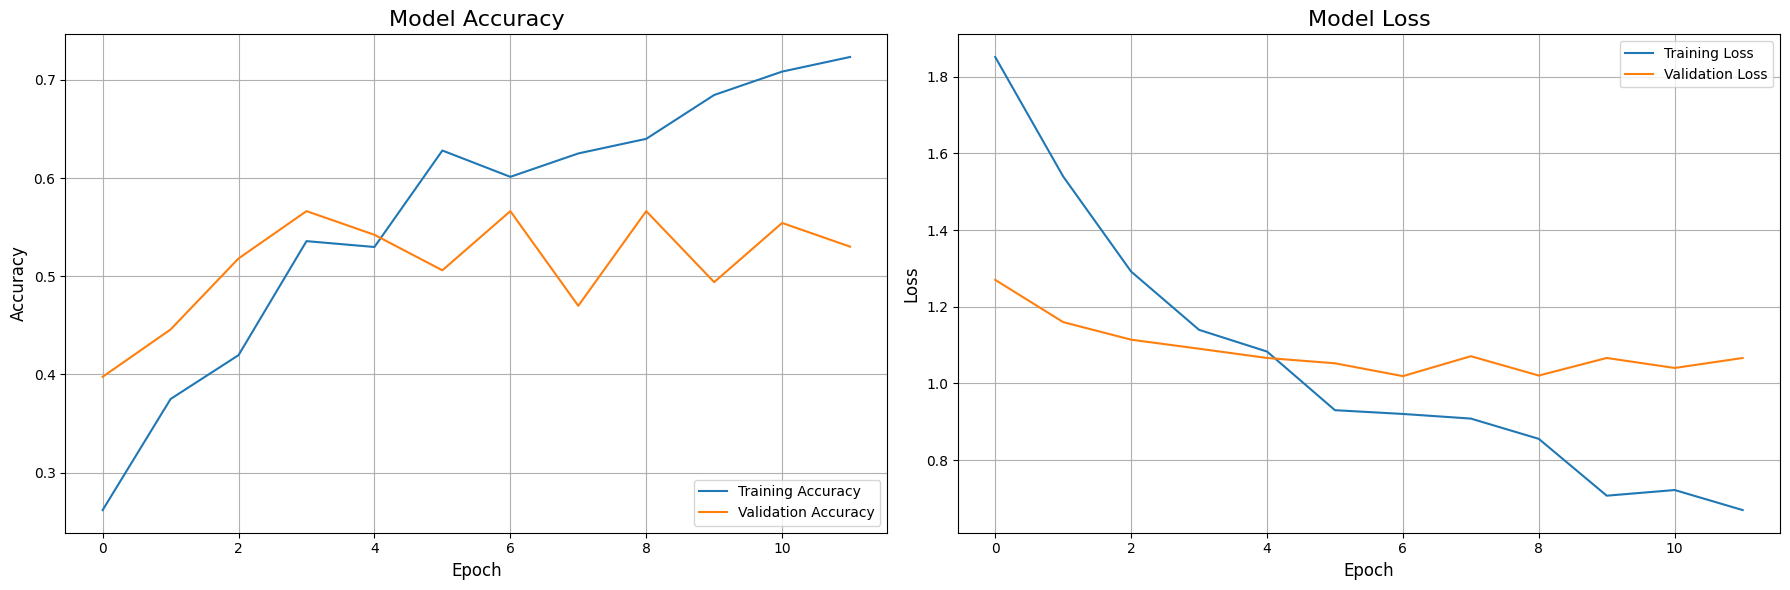

In [19]:
#@title 11. [결과 분석 보강] 학습 곡선 시각화 (Loss & Accuracy - 영문)

print("\nPlotting training history...")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Accuracy Plot (정확도)
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True)

# Loss Plot (손실)
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [20]:
#@title 12. [결과 분석] 최종 평가: 분류 리포트 및 혼동 행렬 (영문)
# (원본 노트북의 스니펫 코드 재구성)

print("\n--- Final Model Evaluation on Validation Set ---")

# 검증 데이터셋(val_ds) 전체에 대한 예측 수행
# 1. 실제 라벨(y_true) 추출
# (val_ds를 순회하며 모든 y(라벨) 배치를 연결합니다)
y_true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# 2. 예측 라벨(y_pred) 생성
y_pred_probs = model.predict(val_ds)
y_pred_labels = np.argmax(y_pred_probs, axis=1) # 확률 -> 가장 높은 클래스 인덱스로 변환

# 3. 분류 리포트 (Classification Report)
print("\n[Classification Report (English)]")
# class_names는 Cell 5에서 tf.data가 로드한 영문 이름 리스트를 사용
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))



--- Final Model Evaluation on Validation Set ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step

[Classification Report (English)]
                  precision    recall  f1-score   support

APPLE ROT LEAVES       0.50      0.35      0.41        20
  HEALTHY LEAVES       0.71      1.00      0.83         5
     LEAF BLOTCH       0.52      0.64      0.57        25
     SCAB LEAVES       0.61      0.58      0.59        33

        accuracy                           0.57        83
       macro avg       0.59      0.64      0.60        83
    weighted avg       0.56      0.57      0.56        83




Plotting Confusion Matrix...


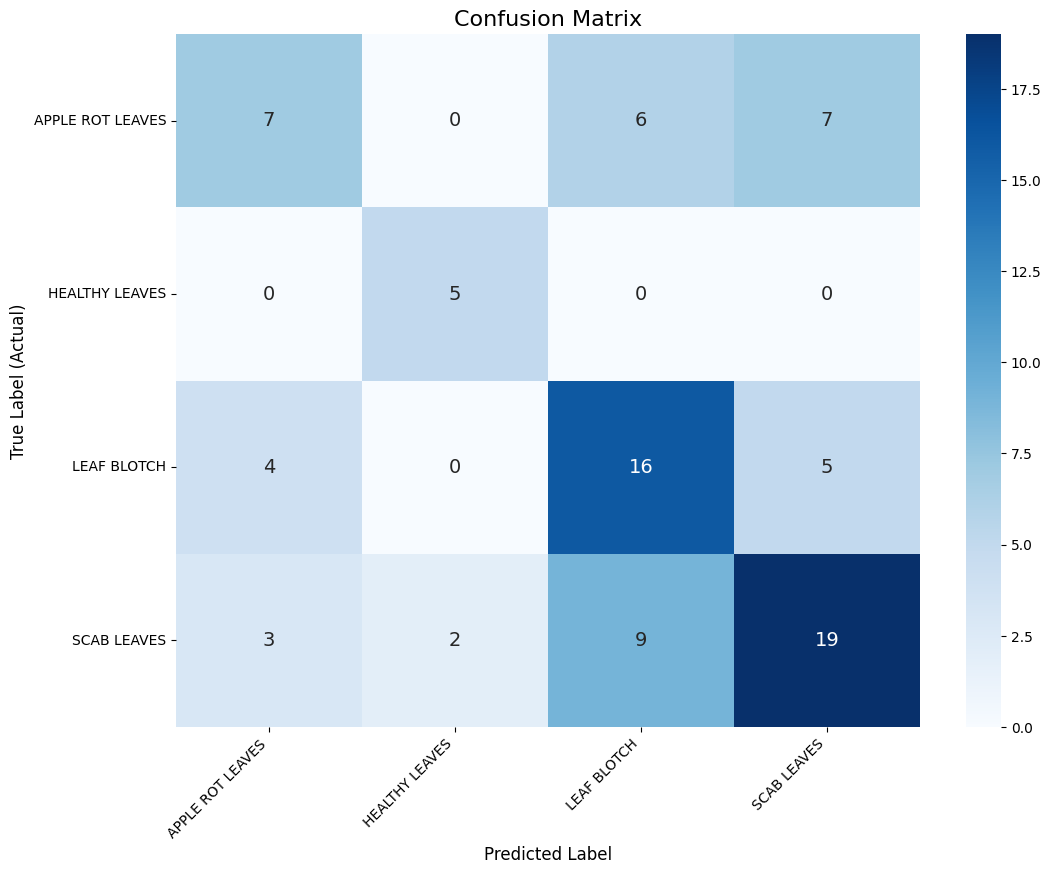

In [21]:
# 4. 혼동 행렬 (Confusion Matrix) 시각화
print("\nPlotting Confusion Matrix...")
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 14})

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label (Actual)', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()